# <center> Project One </center>
### <center> Part 3 </center>
### <center> Dan Ortiz </center>
### <center> W205 Thursday 4:00 PM </center>
### <center> 9/27/2020 </center>

## Part 3 - Employ notebooks to synthesize query project results

## Problem Statement

- You're a data scientist at Lyft Bay Wheels (https://www.lyft.com/bikes/bay-wheels), formerly known as Ford GoBike, the
  company running Bay Area Bikeshare. You are trying to increase ridership, and
  you want to offer deals through the mobile app to do so. 

- What are the 5 most popular trips that you would call "commuter trips"? 
  
- What are your recommendations for offers (justify based on your findings)?

### Findings and Reccomendations

   - Interesting Findings
      - Lyft Bay Wheels most popular commuter routes connect patrons from one mode of transportation to another.
      
      - There is directionality in the flow of commuters departing and arriving at stations.
      
      - 8.45% of all trips originate or terminate at the 2nd and Townsend terminal. In addition, 8 of the most popular days coordinate with Giants Games at Oracle Park.
      
      - Most patrons traveling to and from Oracle Park live in:
      
         - Mission District
         
         - Greater Oakland Area
         
         - Greater San Rafael Area
 
   - Recommended Promotions
   
      - Push promotions from the Lyft App during the 9th inning to people in the geo-area of Oracle Park.
      
      - Push promotions for Morning and Afternoon commuters for intermodal connecting.
      
      - Offer a season pass for Giants season pass holders in the identified districts to increase ridership to and from the baseball games.
      
   
   - Recommended Further Lines of Inquiry
   
      - Weekends tend to be more popular for bike rentals. Why is this?
      
      - Do bike commuters use our bikes to as a primary mode to commute to work or just to connect between modes of public transportation?
      
      - Are there opportunities to advertise on or partner with bay area public transportation to promote Lyft Bay Area Wheels?
   

### What unique characteristics identify a commuter trip from a regular trip?
   
Defining what comprises a commuter trip.
    
   - A Commuter trip must take place Monday - Friday During Rush Hour
   - Rush Hour is defined as 7:00 AM - 9:00 AM and 4:30 PM to 6:30 PM according to [sfgov.org](https://sfgov.org/scorecards/transportation/congestion)
   - Repeat riders would hold a subscription but it is possible for customers to commute so we will count both
   - The originating and terminating station must be different    

In [ ]:
#Run this if you're having trouble running big query in the notebook.
#!pip install google-cloud-bigquery-storage

In [119]:
import pandas as pd
import matplotlib.pyplot as plt

In [116]:
%%bigquery commuter_trip

SELECT start_station_name,
       end_station_name,
       SUM(CASE WHEN TIME(start_date) > TIME(7, 0, 0) AND TIME(start_date) < TIME(9, 0, 0) THEN 1 ELSE 0 END) +
       SUM(CASE WHEN TIME(start_date) > TIME(16, 30, 0) AND TIME(start_date) < TIME(18, 30, 0) THEN 1 ELSE 0 END) AS total_trips,
       SUM(CASE WHEN TIME(start_date) > TIME(7, 0, 0) AND TIME(start_date) < TIME(9, 0, 0) THEN 1 ELSE 0 END) AS am_trips,
       SUM(CASE WHEN TIME(start_date) > TIME(16, 30, 0) AND TIME(start_date) < TIME(18, 30, 0) THEN 1 ELSE 0 END) AS pm_trips,
FROM bigquery-public-data.san_francisco.bikeshare_trips
WHERE EXTRACT(DAYOFWEEK FROM start_date) != 1 
      AND EXTRACT(DAYOFWEEK FROM start_date) != 7
      AND start_station_id != end_station_id
GROUP BY start_station_name, end_station_name
ORDER BY total_trips DESC
LIMIT 5

In [123]:
commuter_trip

,start_station_name,end_station_name,total_trips,am_trips,pm_trips
0,Harry Bridges Plaza (Ferry Building),2nd at Townsend,4141,3673,468
1,Embarcadero at Sansome,Steuart at Market,4001,799,3202
2,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building),3877,2546,1331
3,2nd at Townsend,Harry Bridges Plaza (Ferry Building),3825,511,3314
4,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),3773,588,3185


Observations
   - Most commuter trips are taking place in the evening
   - Commuter flow has a unique directional flow
   - Most of these stops are connected other modes of transportation
   - Second and Townsend is unique. It connects from intermodal to Oracle Park. When do trips to this station peak, what time and date is this.
   - What’s special about the south beach geography that has the most trips?

### When do our subscribers and customers ride our bikes?

In [54]:
%%bigquery ride_times

SELECT EXTRACT(HOUR FROM start_date) AS Hour,
       EXTRACT(DAYOFWEEK FROM start_date) AS Day,
       COUNT(trip_id) AS Trips
FROM bigquery-public-data.san_francisco.bikeshare_trips
WHERE subscriber_type = "Customer"
GROUP BY Day, Hour
ORDER BY Day, Hour

In [55]:
ride_times["day_hour"] = ride_times["Day"].astype(str) + "." + ride_times["Hour"].astype(str)

Text(0, 0.5, 'Number of Rides')

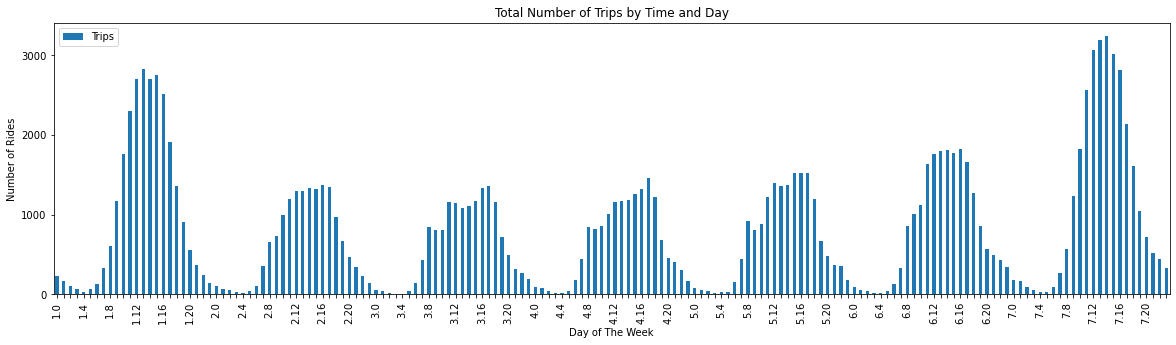

In [57]:
rt_plot = ride_times.plot(x = "day_hour", y = "Trips", kind = "bar", title ="Total Number of Trips by Time and Day", figsize=(20,5))
rt_plot.locator_params(axis='y', nbins=6)
every_nth = 4
for n, label in enumerate(rt_plot.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
rt_plot.set_xlabel("Day of The Week")
rt_plot.set_ylabel("Number of Rides")

# can this be done with a stack bar chart

Observations
   - Slight peak during commute times during the week
   - Most trips are taken on the weekend
   - Most trips during the week start at 11 AM and end at 8 PM
   - Why do trips peak in the afternoon and not in the morning?
   - Additional study should be focused on how people are using these bikes at the end of the day and not at the beginning of the day

### Is there a connection between ridership at the 2nd and Townsend Station and Giants Baseball Games?

2nd and Townsend station stands out in the list of popular routes because it is the only one that does not connect other transit stations to the bike network. In fact it connects the bike network to Oracle Stadium. Combined with the large amount of ridership on the weekend, is there a connection?

In [87]:
%%bigquery second_and_t

SELECT EXTRACT(DATE FROM start_date) AS Ride_Date,
       COUNT(trip_id) AS Trips
FROM bigquery-public-data.san_francisco.bikeshare_trips
WHERE end_station_name = "2nd at Townsend"
GROUP BY Ride_Date
ORDER BY Trips DESC
LIMIT 20

Text(0, 0.5, 'number of Trips')

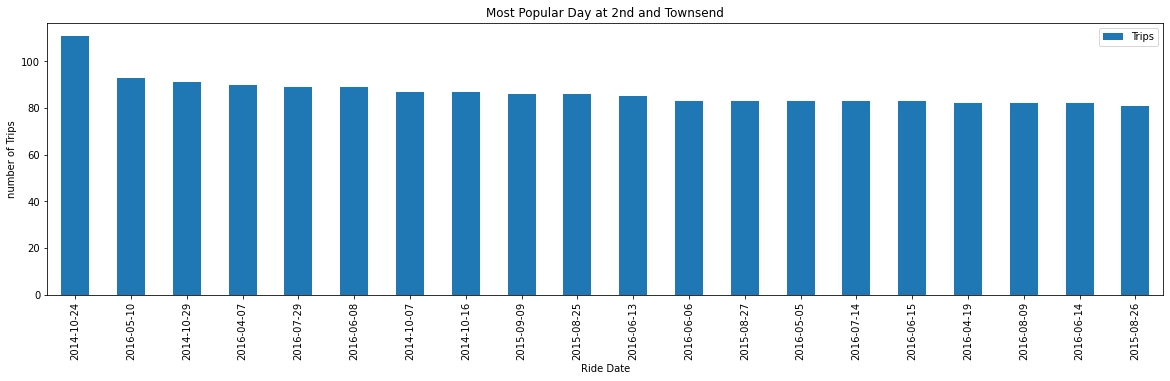

In [88]:
st_plot = second_and_t.plot(x = "Ride_Date", y = "Trips", kind = "bar", title ="Most Popular Day at 2nd and Townsend", figsize=(20,5))
st_plot.set_xlabel("Ride Date")
st_plot.set_ylabel("number of Trips")

Cross referencing Giants games from [baseball-reference.com](https://www.baseball-reference.com) for the top 10 days above yields:

|Date|Oponent|Field|
|----|-------|-----|
|2014-10-24|Royals|Home|
|2016-05-10| Mets |Away|
|2014-10-29|Royals|Away|
|2016-04-07|Dodgers|Home|
|2016-07-29|Nationals|Home
|2016-06-08|Red Sox|Home|
|2014-10-07|Nationals|Home|
|2014-10-16|Cardinals|Home|
|2015-09-09| Mets |Away|
|2015-08-25| Cubs |Home|

There seems to be a correlation between game day and ridership at this station. The 2014 Royal games reflect the 2014 World Series and AT&T field (Now Oracle Park) offered standing room viewing of the game in Kansas City. Therefore 8 out of the 10 busiest days for the station is correlated to the Giants game.

Key Observations
   - There is a correlation between Giants games and the use of the 2nd and Townsend station

### What are the popular arival and departure routes for the the 2nd and Townsend Routs?




In [89]:
%%bigquery arival_2_and_t

SELECT start_station_name,
       end_station_name,
       COUNT(trip_id) AS Trips
FROM bigquery-public-data.san_francisco.bikeshare_trips
WHERE end_station_name = "2nd at Townsend"
   AND start_station_id != end_station_id
GROUP BY end_station_name, start_station_name
ORDER BY Trips DESC
LIMIT 5

In [90]:
arival_2_and_t

,start_station_name,end_station_name,Trips
0,Harry Bridges Plaza (Ferry Building),2nd at Townsend,6888
1,Steuart at Market,2nd at Townsend,6039
2,Temporary Transbay Terminal (Howard at Beale),2nd at Townsend,3207
3,San Francisco Caltrain (Townsend at 4th),2nd at Townsend,2492
4,Market at Sansome,2nd at Townsend,2482


Key Observation
   - The most popular arrival and departure stations connected to 2nd and Townsend connects other modes of transportation to the park
   - People using the bikes to get from a modal station to the park may be coming from further out of town

In [91]:
%%bigquery departure_2_and_t

SELECT start_station_name,
       end_station_name,
       COUNT(trip_id) AS Trips
FROM bigquery-public-data.san_francisco.bikeshare_trips
WHERE start_station_name = "2nd at Townsend"
   AND start_station_id != end_station_id
GROUP BY start_station_name, end_station_name
ORDER BY Trips DESC
LIMIT 5

In [ ]:
departure_2_and_t

Key Observations
   - These are the same routes that were shown in arrival
   - The popularity of the routes is different. Potential an opportunity to convince customers to commute both ways to and from the games

### Where do these Subscribers live?

In [109]:
%%bigquery subs_vs_cust

SELECT SUM(CASE WHEN subscriber_type = "Subscriber" THEN 1 ELSE 0 END) AS subscriber,
       SUM(CASE WHEN subscriber_type = "Customer" THEN 1 ELSE 0 END) AS customer,
FROM bigquery-public-data.san_francisco.bikeshare_trips
WHERE (start_station_name = "Harry Bridges Plaza (Ferry Building)" AND end_station_name = "2nd at Townsend")
   OR (start_station_name = "Steuart at Market" AND end_station_name = "2nd at Townsend")
   OR (start_station_name = "Temporary Transbay Terminal (Howard at Beale)" AND end_station_name = "2nd at Townsend")
   OR (start_station_name = "San Francisco Caltrain (Townsend at 4th)" AND end_station_name = "2nd at Townsend")
   OR (start_station_name = "Market at Sansome" AND end_station_name = "2nd at Townsend")
   OR (start_station_name = "2nd at Townsend" AND end_station_name = "Harry Bridges Plaza (Ferry Building)")
   OR (start_station_name = "2nd at Townsend" AND end_station_name = "Steuart at Market")
   OR (start_station_name = "2nd at Townsend" AND end_station_name = "Market at Sansome")
   OR (start_station_name = "2nd at Townsend" AND end_station_name = "San Francisco Caltrain (Townsend at 4th)")
   OR (start_station_name = "2nd at Townsend" AND end_station_name = "Temporary Transbay Terminal (Howard at Beale)")
   AND start_station_id != end_station_id

In [110]:
subs_vs_cust

,subscriber,customer
0,37999,2318


Key Observation
   - Most of the people using the bikes to travel to and from the Giants games are Subscribers,

In [106]:
%%bigquery subs_locations

SELECT zip_code,
       SUM(CASE WHEN subscriber_type = "Subscriber" THEN 1 ELSE 0 END) AS Trips
FROM bigquery-public-data.san_francisco.bikeshare_trips
WHERE (start_station_name = "Harry Bridges Plaza (Ferry Building)" AND end_station_name = "2nd at Townsend")
   OR (start_station_name = "Steuart at Market" AND end_station_name = "2nd at Townsend")
   OR (start_station_name = "Temporary Transbay Terminal (Howard at Beale)" AND end_station_name = "2nd at Townsend")
   OR (start_station_name = "San Francisco Caltrain (Townsend at 4th)" AND end_station_name = "2nd at Townsend")
   OR (start_station_name = "Market at Sansome" AND end_station_name = "2nd at Townsend")
   OR (start_station_name = "2nd at Townsend" AND end_station_name = "Harry Bridges Plaza (Ferry Building)")
   OR (start_station_name = "2nd at Townsend" AND end_station_name = "Steuart at Market")
   OR (start_station_name = "2nd at Townsend" AND end_station_name = "Market at Sansome")
   OR (start_station_name = "2nd at Townsend" AND end_station_name = "San Francisco Caltrain (Townsend at 4th)")
   OR (start_station_name = "2nd at Townsend" AND end_station_name = "Temporary Transbay Terminal (Howard at Beale)")
   AND start_station_id != end_station_id
GROUP BY zip_code
ORDER BY Trips DESC
Limit 10

Text(0, 0.5, 'number of Trips')

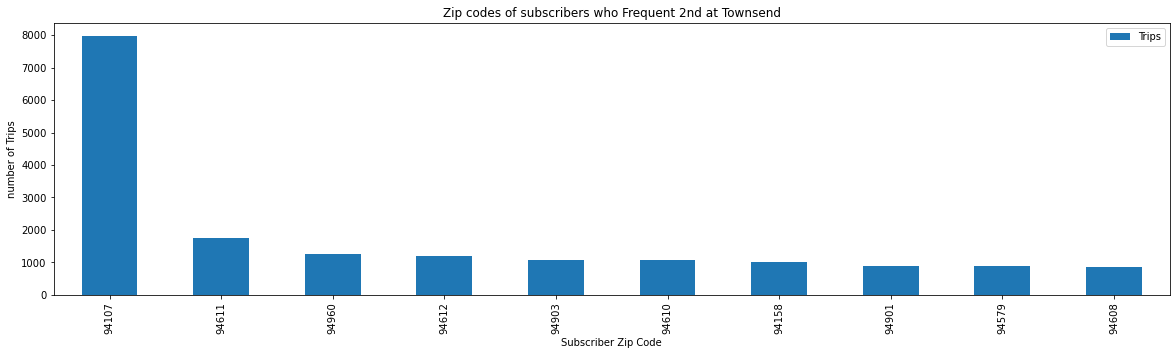

In [124]:
loc_plot = subs_locations.plot(x = "zip_code", y = "Trips", kind = "bar", title ="Zip codes of subscribers who Frequent 2nd at Townsend", figsize=(20,5))
loc_plot.set_xlabel("Subscriber Zip Code")
loc_plot.set_ylabel("number of Trips")

Observations
   - Cross referencing on Goole Maps indicates the Key Locations are:
       - Mision District
       - Greater Oakland 
       - Greater San Rafial

## What is the current percentage of ridership traveling to and from the 2nd and Townsend Station?

In [125]:
%%bigquery per_ride

SELECT COUNT(trip_id) AS total_trips,
       SUM(CASE WHEN start_station_name = "2nd at Townsend" OR end_station_name = "2nd at Townsend" THEN 1 ELSE 0 END) AS term_prints,
       TRUNC((SUM(CASE WHEN start_station_name = "2nd at Townsend" OR end_station_name = "2nd at Townsend" THEN 1 ELSE 0 END) / COUNT(trip_id) * 100), 2) AS percent
FROM bigquery-public-data.san_francisco.bikeshare_trips

In [126]:
per_ride

,total_trips,term_prints,percent
0,983648,83186,8.45
